# 🧪 Exploratory Data Analysis: Metabolomic Signatures in Type 2 Diabetes (T2D)

This notebook presents a comprehensive **exploratory data analysis (EDA)** of a metabolomics dataset focused on **Type 2 Diabetes (T2D)**. The aim is to uncover patterns, correlations, and biologically meaningful relationships between various metabolites and disease status. The analysis is intended as a foundational step toward building predictive models and gaining biological insight into T2D.

---

## 📌 Key Components

- **🔢 Dataset Overview**: Summary of data structure, sample size, feature distribution, and initial cleaning steps.
- **📊 Correlation Analysis**: Spearman correlations between metabolites, highlighting those with |r| ≥ 0.4.
- **🧬 Biological Interpretation**: Annotated interpretation of top metabolite correlations, with potential mechanistic links to insulin resistance, glycemic control, lipid metabolism, and gut microbial activity.
- **📈 Feature Relevance for Modeling**: Findings help identify biologically relevant and statistically significant features for downstream machine learning or statistical modeling.

---

## 📁 Dataset Details

The dataset consists of metabolite concentration measurements from a cohort of individuals classified by T2D disease status. Each feature represents a metabolite measured using high-throughput mass spectrometry. The dataset may include missing values, outliers, and varying data scales, all of which are handled during preprocessing.

---

## 🧭 Methodological Approach

- Data inspection and validation
- Correlation heatmap and feature-level analysis
- Manual annotation of top correlations
- Preliminary statistical testing for group-level differences (e.g., Mann–Whitney U test)
- Optional SHAP-based feature interpretability (if modeling is extended)

---

## 🎯 Objective

To identify metabolomic features that differ meaningfully between individuals with and without T2D, and to generate hypotheses for future biomarker discovery or predictive modeling.

---

## 🧾 Credits and Funding (if applicable)

*This analysis is part of an independent research exploration into metabolomic signatures of Type 2 Diabetes. Please cite the original data source or publication if reusing the data.*

Source: https://www.metabolomicsworkbench.org/

---

*Author: [Tomasz Lasota]*  
*Date: [2025-06-29]*


## Part 1: Exploratory Data Analysis

## 1. Settings and Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import math
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.impute import SimpleImputer
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from itertools import product
from tabulate import tabulate

In [2]:
# Define class for handling notebook and dataset imports and settings
class CF:

    def __init__(self):
        self.dataset = Path("ST001906_1.txt")

        if not self.dataset.exists():
            raise FileNotFoundError(f"Dataset {self.dataset} not found.")


## 2. Data Exploration

In [3]:
# load dataset skipping the first and last 3 rows
df = pd.read_csv(
    CF().dataset, 
    sep="\t", 
    header=0, 
    skiprows=1,
    skipfooter=3,
    engine="python"
)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Metabolite_name  79 non-null     object
 1   RefMet_name      79 non-null     object
 2   C01              79 non-null     object
 3   C02              79 non-null     object
 4   C03              79 non-null     object
 5   C04              77 non-null     object
 6   C05              79 non-null     object
 7   C06              79 non-null     object
 8   C07              79 non-null     object
 9   C08              79 non-null     object
 10  C09              79 non-null     object
 11  C10              79 non-null     object
 12  C11              78 non-null     object
 13  C12              79 non-null     object
 14  C13              78 non-null     object
 15  C14              79 non-null     object
 16  C15              78 non-null     object
 17  C16              78 non-null     obje

In [5]:
# test for duplicates 
df.duplicated().sum()

np.int64(0)

In [6]:
df.head()

,Metabolite_name,RefMet_name,C01,C02,C03,C04,C05,C06,C07,C08,...,P23B,P24B,P25B,P26B,P27B,P29B,P30B,P31B,P32B,P33B
0,Factors,-,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,...,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes
1,1_5-Anhydroglucitol,"1,5-Anhydrosorbitol",76134.0679,68229.8179,75060.0460,21889.5860,61684.2890,115496.8453,77569.5444,87619.4513,...,1366.5750,4011.0743,1485.9307,4361.8853,23685.9709,13167.1581,42091.9933,2360.8300,889.5784,5389.3421
2,2-Aminobutyrate,2-Aminobutyric acid,2483.6464,1171.0519,1812.2221,982.1933,1525.7878,1090.4060,1269.0313,1786.2425,...,2203.0673,3151.7086,2574.6249,3184.0889,2672.3013,2889.2573,2284.7122,3026.2174,3586.0458,3237.7158
3,2-Hydroxybutyrate,2-Hydroxybutyric acid,4785.6271,4043.5030,3822.1668,4140.3742,6823.5424,9683.3429,6729.0747,6613.6143,...,14332.5561,16349.3766,16522.0347,21152.4515,15942.5127,15007.9743,10137.0140,17545.8158,8798.9741,22780.4208
4,3-Aminoisobutyrate,3-Aminoisobutanoic acid,3170.5029,3031.3133,3015.3690,3579.3690,2776.2411,4072.6505,3019.2438,2940.5403,...,6140.5615,3852.9904,3404.6428,5132.2698,4150.2105,3362.3410,3887.4223,2959.2192,4809.2734,3006.8964


In [7]:
# Drop one of the columns with the metabolite names
df.drop(columns=["RefMet_name"], inplace=True)


In [8]:
# Transpose the dataframe to have metabolites as columns
# rename the approprite columns containung the class labels and sample IDs
df = df.T
df.columns = df.iloc[0] # use the first row as the column names
df = df.iloc[1:]        # drop the first row
df.reset_index(inplace=True)

df.rename(columns={
    "index": "ID",
    "Factors": "Class",
    "1_5-Anhydroglucitol": "1,5-Anhydroglucitol",
}, inplace=True)

df.columns.name = None  # remove the name of the index column


In [9]:
df.head()

,ID,Class,"1,5-Anhydroglucitol",2-Aminobutyrate,2-Hydroxybutyrate,3-Aminoisobutyrate,3-Hydroxybutyrate,Alanine,Allose,alpha-Tocopherol,...,Succinate,Threonate,Threonine,Tryptophan,Tyrosine,Urate,Urea,Uridine,Valine,Xylulose
0,C01,Diagnosis:Control,76134.0679,2483.6464,4785.6271,3170.5029,78663.0271,325359.7759,13080.7146,17004.6243,...,2298.1521,5507.2429,53797.8621,196307.0489,132745.3571,227581.6297,2500712.2060,2388.3416,402362.8160,902.2380
1,C02,Diagnosis:Control,68229.8179,1171.0519,4043.5030,3031.3133,17390.0075,323430.1298,12230.4685,21773.9858,...,2287.1496,2123.0647,50510.9227,261875.3204,182488.5616,144834.5131,2728527.7610,2229.2537,463447.9622,492.9723
2,C03,Diagnosis:Control,75060.0460,1812.2221,3822.1668,3015.3690,17036.9851,257628.0056,9330.0788,14931.4521,...,2829.0987,3339.2427,41762.9209,226547.3473,118124.2550,231965.0438,2489866.2910,1478.4680,352389.1496,877.0040
3,C04,Diagnosis:Control,21889.5860,982.1933,4140.3742,3579.3690,14830.6049,480618.6042,9259.4009,13318.2075,...,2789.5426,2929.9679,43210.8286,166942.0816,123024.1937,102890.4736,1480693.2910,1379.7791,307739.7556,697.2607
4,C05,Diagnosis:Control,61684.2890,1525.7878,6823.5424,2776.2411,17699.7571,367881.7294,10301.2117,13517.0489,...,3720.4811,3280.4422,35082.3522,186303.5238,142509.9754,205703.5966,1839377.0810,1327.8250,365375.5512,861.3556


In [10]:
# convert the class labels to 0 and 1
df["Class"] = df["Class"].map({
    "Diagnosis:Control": 0,
    "Diagnosis:Diabetes": 1})
# convert the data objects into numbers where possible
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except Exception:
        print(f"Column {col} could not be converted to numeric")

Column ID could not be converted to numeric


In [11]:
def missing_values_summary(df:pd.DataFrame = None):
    if df is not None:
        missing_values = df.isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        missing_data = pd.DataFrame({
            'Missing Values': missing_values,
            'Percentage': missing_percentage
        })

        # Filter columns with missing values
        missing_data = missing_data[missing_data['Missing Values'] > 0]
        # Sort by the number of missing values for better readability
        missing_data = missing_data.sort_values(by='Missing Values', ascending=False)
        missing_data_transposed = missing_data.transpose()
        
        # Adjust display options for better visibility
        pd.set_option('display.float_format', '{:.2f}'.format)
        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.width', 1000)       # Increase width for wide tables
        # Display the missing data summary in a professional format using tabulate
        print("🔍 Missing Values Summary:")
        print(tabulate(missing_data_transposed, headers='keys', tablefmt='pretty'))

def get_info(df:pd.DataFrame=None, type:str="percent") -> pd.DataFrame:

        if type.lower() == "percent":
            value = (df.count().values/len(df) * 100).round(3)
            unit = "%"
        elif type.lower() == "count":
            value = df.count().values
            unit = "Count"
        else:
            print("Invalid type argument")
        
        df_info = pd.DataFrame({
            "Column Names": df.columns,
            f"Non-null values ({unit})": value,
            "Data Type": df.dtypes.values
        })

        return df_info

In [12]:
print(tabulate(get_info(df), headers='keys', tablefmt='pretty'))

+----+-----------------------+---------------------+-----------+
|    |     Column Names      | Non-null values (%) | Data Type |
+----+-----------------------+---------------------+-----------+
| 0  |          ID           |        100.0        |  object   |
| 1  |         Class         |        100.0        |   int64   |
| 2  |  1,5-Anhydroglucitol  |        100.0        |  float64  |
| 3  |    2-Aminobutyrate    |        100.0        |  float64  |
| 4  |   2-Hydroxybutyrate   |        100.0        |  float64  |
| 5  |  3-Aminoisobutyrate   |        100.0        |  float64  |
| 6  |   3-Hydroxybutyrate   |        100.0        |  float64  |
| 7  |        Alanine        |        100.0        |  float64  |
| 8  |        Allose         |       98.361        |  float64  |
| 9  |   alpha-Tocopherol    |        100.0        |  float64  |
| 10 |       Arabinose       |        100.0        |  float64  |
| 11 |       Arginine        |        100.0        |  float64  |
| 12 |      Asparagine   

In [13]:
# Basic descriptive statistics
df.describe()

,Class,"1,5-Anhydroglucitol",2-Aminobutyrate,2-Hydroxybutyrate,3-Aminoisobutyrate,3-Hydroxybutyrate,Alanine,Allose,alpha-Tocopherol,Arabinose,...,Succinate,Threonate,Threonine,Tryptophan,Tyrosine,Urate,Urea,Uridine,Valine,Xylulose
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,60.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,6.100000e+01,61.000000,61.000000,61.000000
mean,0.508197,40880.637982,2119.166090,10881.508900,3357.055641,76975.547415,392346.945926,14720.395377,15928.659567,508.818472,...,2377.259621,3503.297731,40091.115074,188024.001170,135009.009959,164419.081715,2.165805e+06,1881.689859,419079.895003,955.144870
std,0.504082,33364.642840,795.585692,5486.700165,902.750248,78855.677869,102175.734405,5641.395620,4887.833643,290.104188,...,704.051509,2201.009677,10284.258310,34345.773134,24279.559654,41871.321461,5.710768e+05,521.032839,95083.833836,374.471377
min,0.000000,889.578400,526.621200,3822.166800,1980.980500,14117.535900,95288.601200,8784.138400,8071.738200,83.183000,...,1253.817200,818.950600,13104.349100,102714.665700,91448.036800,91506.709100,1.297209e+06,989.242600,108689.961300,414.758700
25%,0.000000,10562.167700,1592.369900,6721.705200,2952.793500,23445.070300,323430.129800,10562.006275,12619.209000,322.551300,...,1765.012600,2144.429200,33234.266300,165262.439800,118124.255000,133447.493300,1.807020e+06,1458.638000,358871.780900,678.782000
50%,1.000000,36735.764800,2032.147700,9673.126600,3150.522300,44434.173100,383280.704600,13452.410150,14509.073700,446.973500,...,2287.149600,3062.948900,40655.670400,183653.266200,132308.510900,162234.268500,2.130706e+06,1844.558000,415549.084700,890.503900
75%,1.000000,71367.725400,2685.870900,15007.974300,3647.682800,97269.652300,465394.402200,16658.345375,17725.157600,667.233400,...,2867.828200,4177.609100,46969.390400,206524.091600,147490.242900,194961.070300,2.489866e+06,2239.132100,463447.962200,1133.647100
max,1.000000,115496.845300,4397.556300,28975.823000,7219.206200,372262.774000,675140.720000,33334.776700,36460.662000,1668.365100,...,3780.038800,14739.957400,70849.607000,276209.272000,187237.572200,246924.354900,3.866027e+06,3406.387700,660563.253800,2032.840200


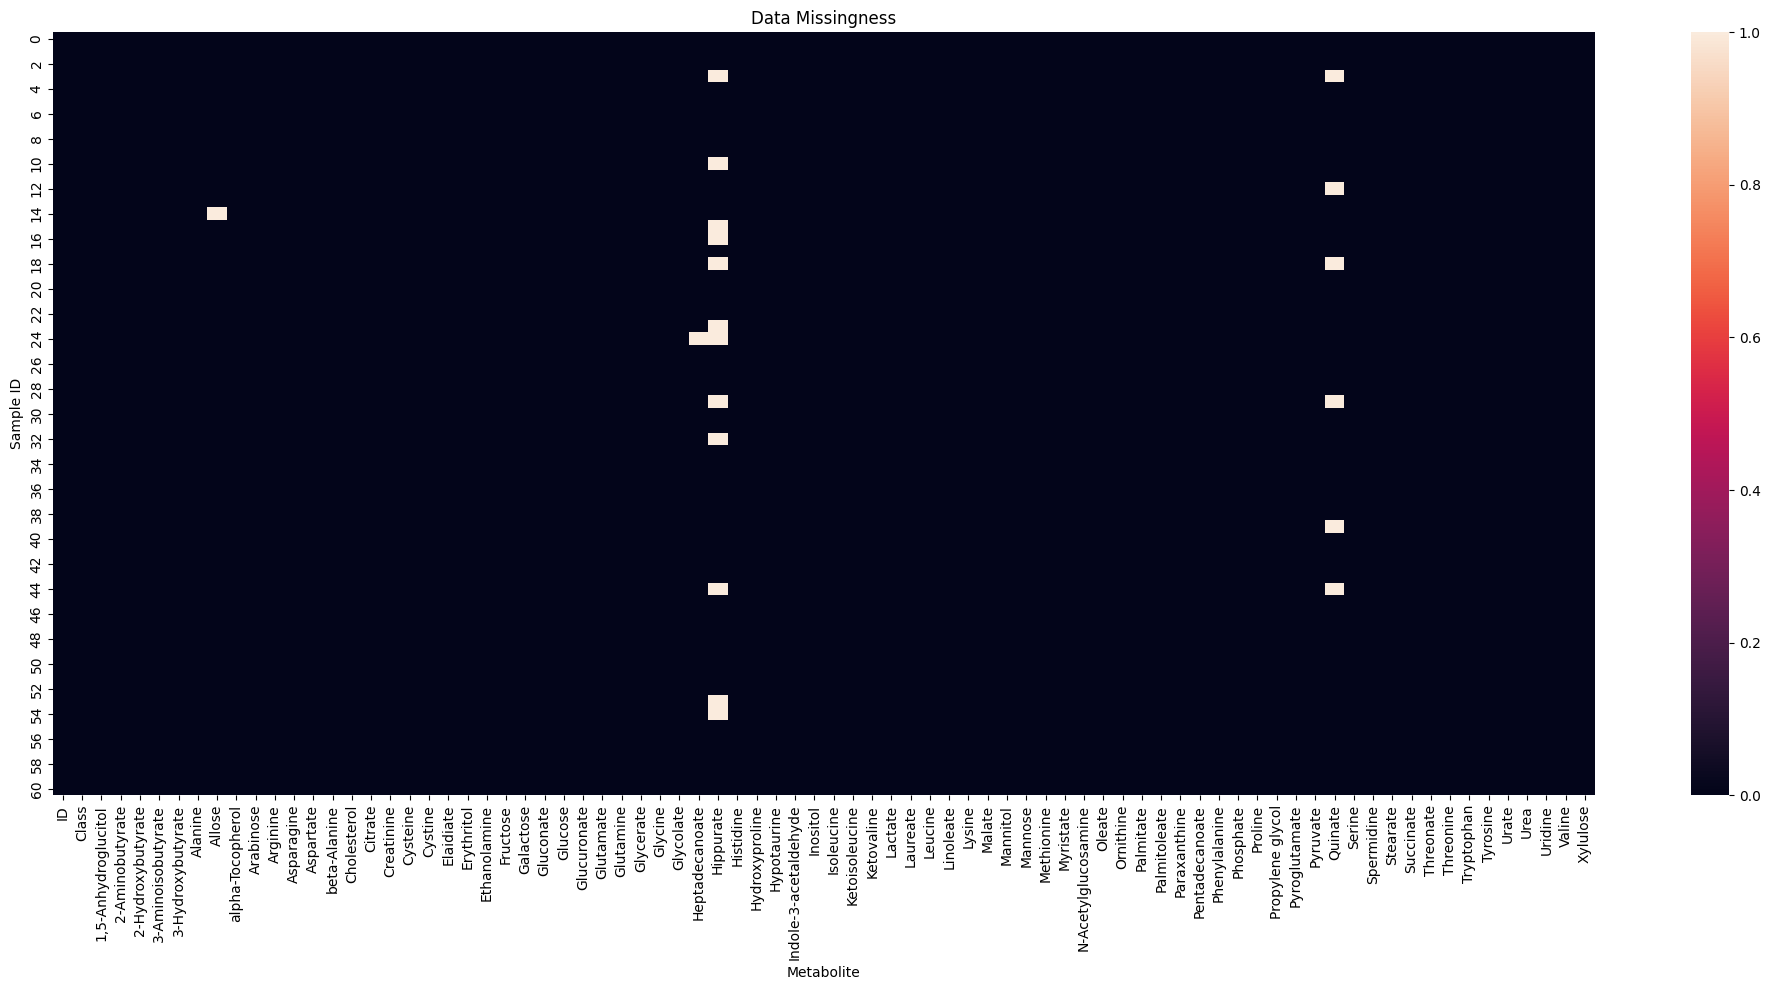

In [14]:
# Vizualise data missigness
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull())
plt.title("Data Missingness")
plt.ylabel("Sample ID")
plt.xlabel("Metabolite")
plt.tight_layout()

In [15]:
missing_values_summary(df)

🔍 Missing Values Summary:
+----------------+--------------------+-------------------+-------------------+-------------------+
|                |     Hippurate      |      Quinate      |  Heptadecanoate   |      Allose       |
+----------------+--------------------+-------------------+-------------------+-------------------+
| Missing Values |        12.0        |        6.0        |        1.0        |        1.0        |
|   Percentage   | 19.672131147540984 | 9.836065573770492 | 1.639344262295082 | 1.639344262295082 |
+----------------+--------------------+-------------------+-------------------+-------------------+


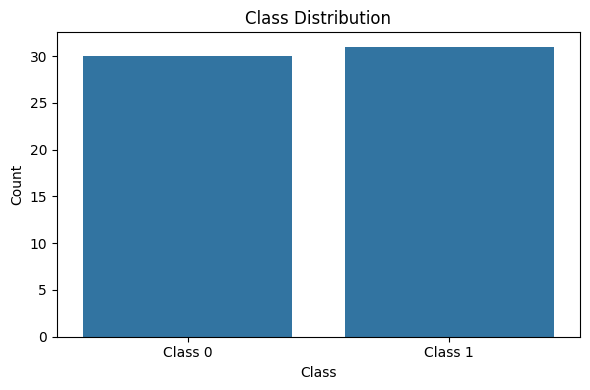

In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Class", data=df)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], labels=["Class 0", "Class 1"])
plt.tight_layout()
plt.show()

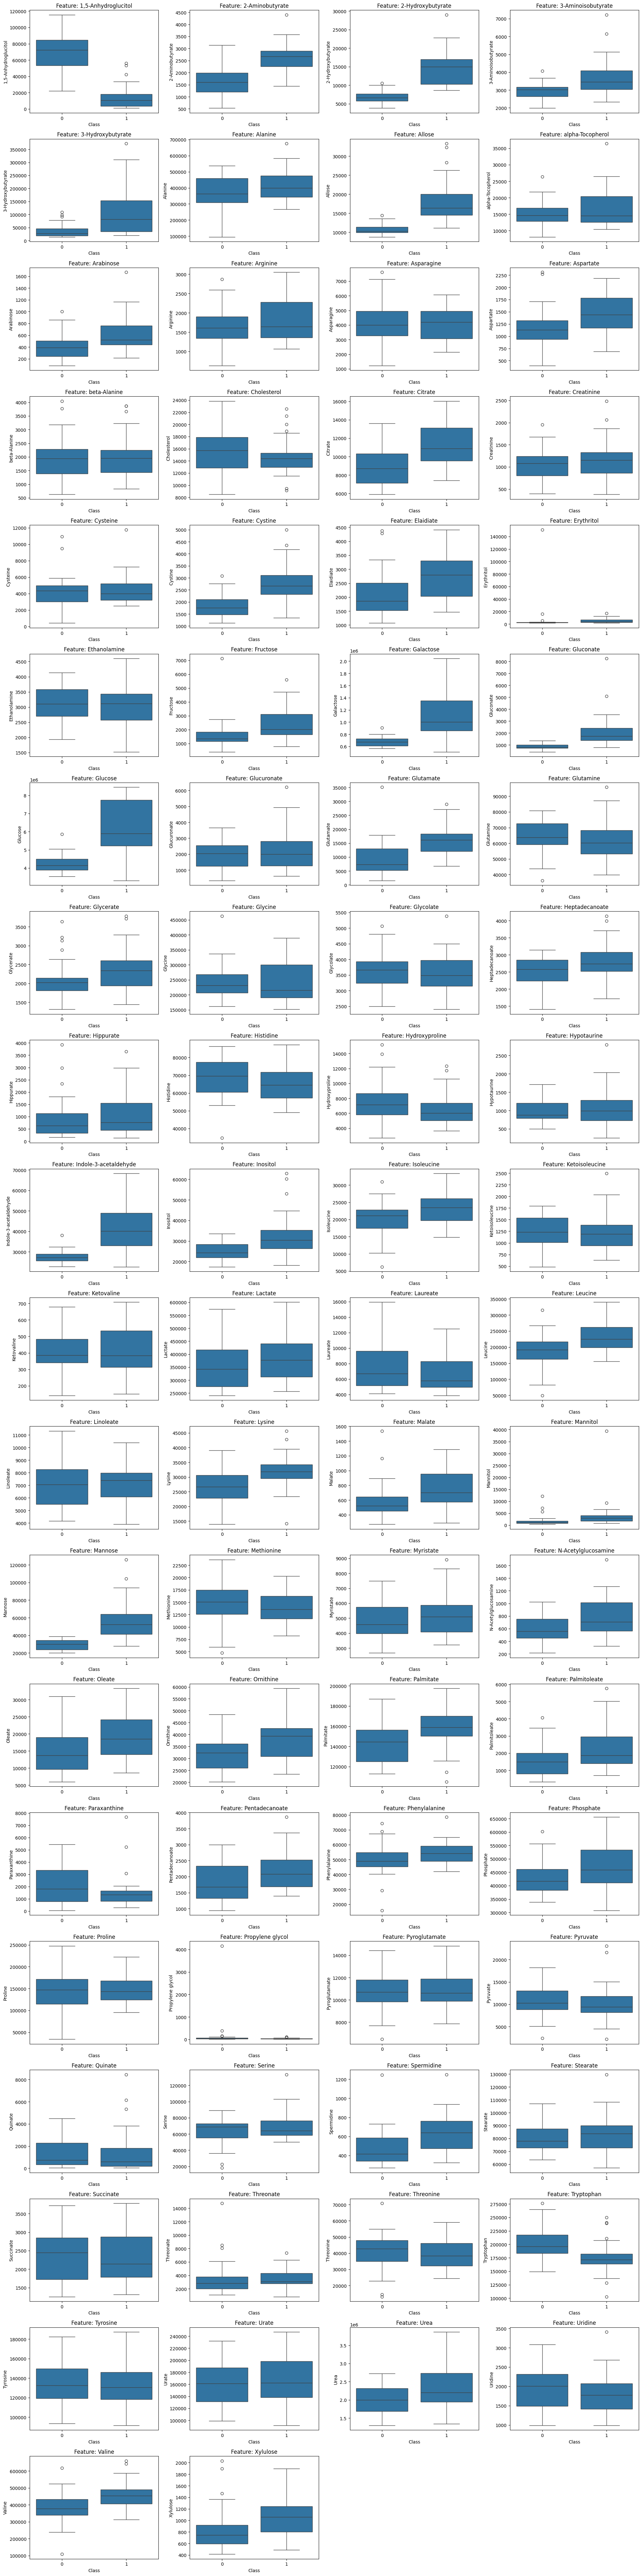

In [17]:
# plot box plots for each metabolite with the class labels
feature_cols = [col for col in df.columns if col != "ID" and col != "Class"]

# Grid set up
cols_per_row = 4
total_plots = len(feature_cols)
rows = math.ceil(total_plots / cols_per_row)

plt.figure(figsize=(cols_per_row * 5, rows * 4))

for i, col in enumerate(feature_cols):
    plt.subplot(rows, cols_per_row, i + 1)  # plt.subplots is 1-based not 0-based
    sns.boxplot(x="Class", y=col, data=df)
    plt.title(f"Feature: {col}")
    plt.tight_layout()

plt.show()


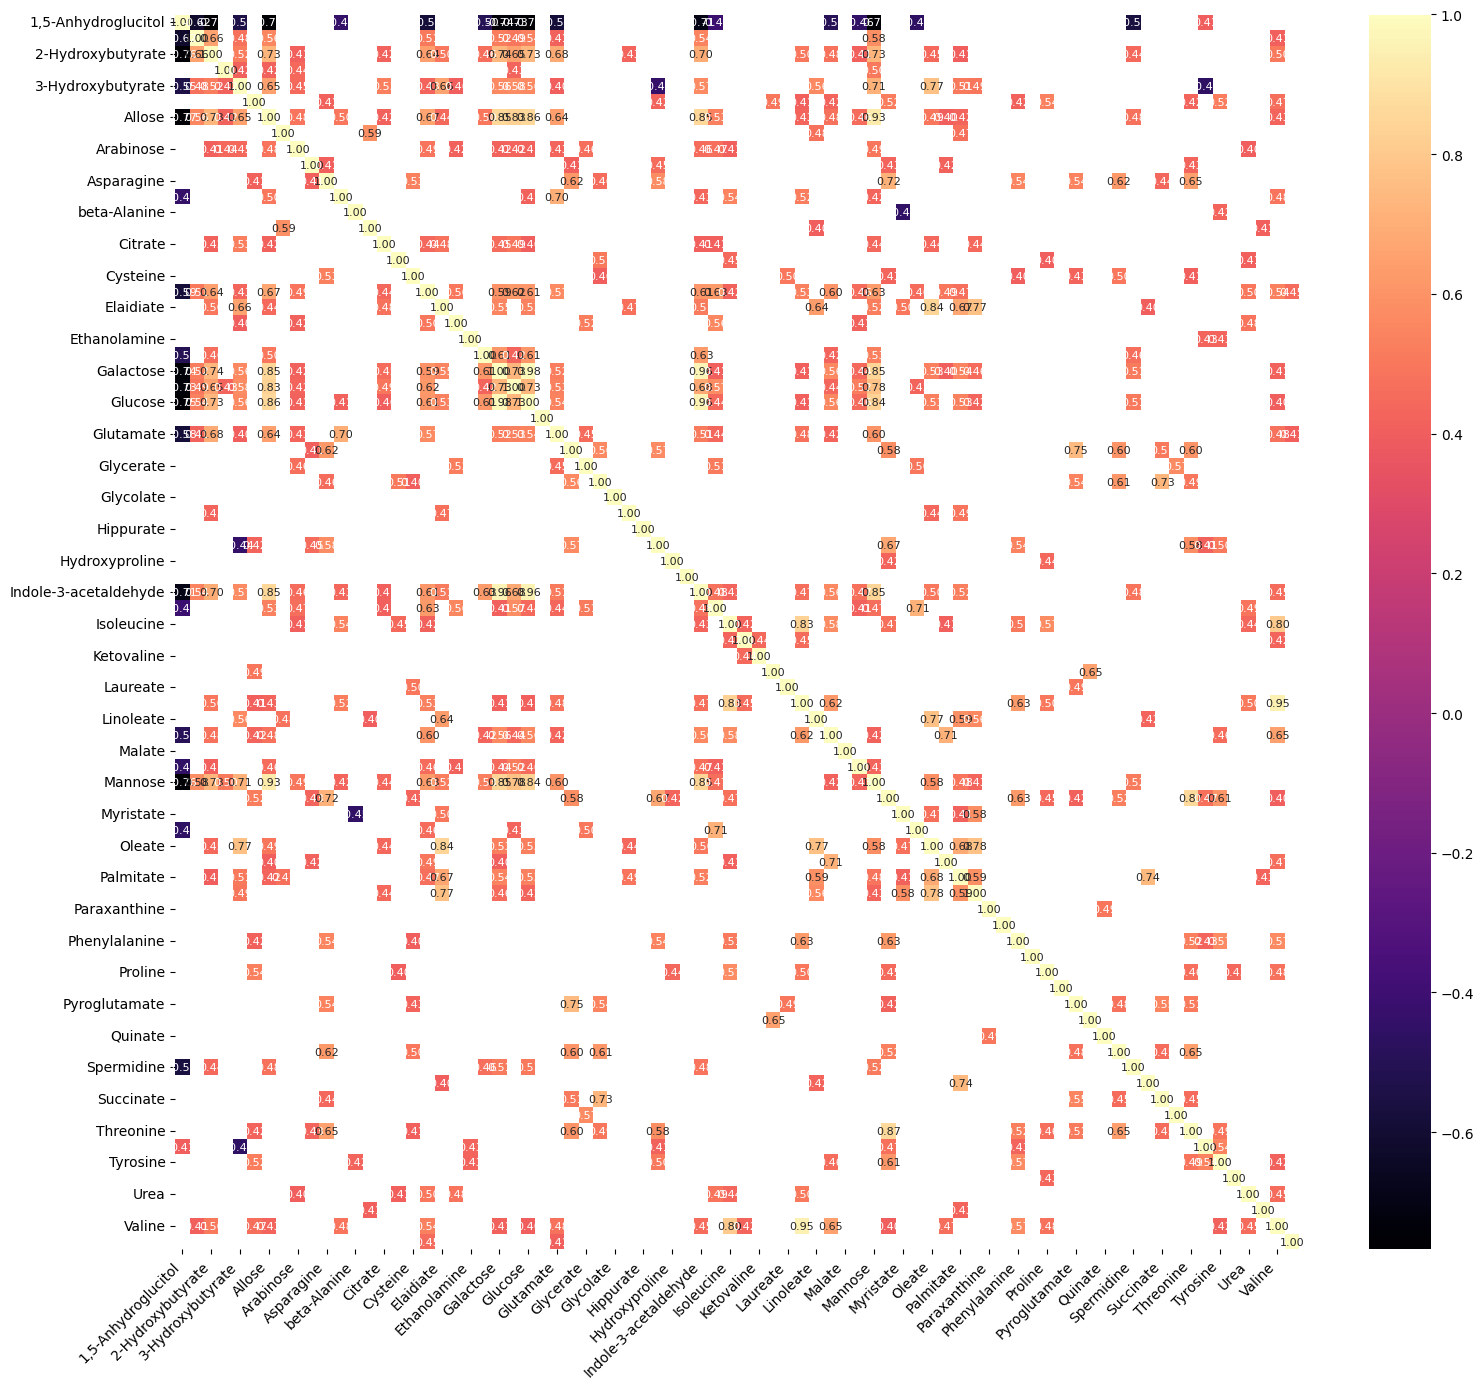

In [18]:
# correlation heatmap

# Compute correlation matrix and mask correlations with |r| < 0.4
corr = df[feature_cols].corr(method="spearman")
mask = np.abs(corr) < 0.4

# Generate the heatmap with correlation values
plt.figure(figsize=(16, 14))
sns.heatmap(corr,
            mask=mask, 
            annot=True, 
            fmt=".2f",         # Limit decimal places
            cmap='magma',      # Use a visually distinct color map
            annot_kws={"size": 8})  # Adjust annotation font size

# Improve tick label appearance
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Spearman Correlation Analysis of Metabolites — Focus on Type 2 Diabetes

This analysis investigates strong positive Spearman correlations (r > 0.4) among quantified metabolites to uncover co-regulated biochemical patterns associated with Type 2 Diabetes (T2D). Spearman correlation is used due to its robustness against non-linearity and non-normal distributions, both common in biological data.

## Summary of Strong Positive Correlations (r > 0.9)

### 1. `Galactose` and `Glucose`  
**Spearman r = 0.982**

**Interpretation:**  
This exceptionally strong correlation is expected, as both are structurally related monosaccharides. Galactose is a C-4 epimer of glucose and shares transporters (e.g., GLUT family) and initial metabolic enzymes (e.g., hexokinase). 

In the context of T2D:
- Elevated glucose levels often lead to dysregulation of hexose metabolism.
- The liver converts galactose to glucose-1-phosphate, linking the two metabolically.
- Shared absorption and transport mechanisms may amplify co-variation in plasma levels.

---

### 2. `Galactose` and `Indole-3-acetaldehyde`  
**Spearman r = 0.960**

**Interpretation:**  
This unexpected but strong correlation could reflect broader dysregulation in sugar and tryptophan metabolism seen in T2D. Indole-3-acetaldehyde is a gut microbiota-derived metabolite from tryptophan degradation.

Possible links:
- Hyperglycemia can alter gut microbiota composition and metabolic activity.
- Galactose metabolism affects gut barrier integrity and microbial exposure.
- Indole derivatives may respond to the same inflammatory or glycemic stressors as galactose.

---

### 3. `Glucose` and `Indole-3-acetaldehyde`  
**Spearman r = 0.958**

**Interpretation:**  
This supports the link between host glycemic state and microbial-derived metabolites. Elevated glucose can:
- Alter the gut microbiota and increase production of indole metabolites.
- Induce host stress pathways (e.g., oxidative stress, immune activation) that interact with microbial metabolism.

Indole compounds have been shown to influence insulin signaling, gut barrier function, and incretin secretion — all relevant to T2D pathophysiology.

---

### 4. `Leucine` and `Valine`  
**Spearman r = 0.946**

**Interpretation:**  
Leucine and valine are branched-chain amino acids (BCAAs). Their strong correlation is biologically plausible due to:
- Shared transport mechanisms (e.g., LAT1)
- Common catabolic pathways in muscle and liver
- Coordinated dietary uptake and metabolic regulation

**Relevance to T2D:**  
- Elevated BCAAs are associated with insulin resistance.
- Impaired BCAA catabolism leads to toxic intermediate buildup, mitochondrial stress, and altered glucose metabolism.
- Their joint elevation is a known early biomarker for T2D risk.

---

### 5. `Allose` and `Mannose`  
**Spearman r = 0.927**

**Interpretation:**  
Both are rare sugars structurally related to glucose. Mannose is implicated in glycosylation, while allose is less studied but may participate in similar pathways.

In T2D:
- Mannose levels increase and may reflect altered protein glycosylation or glucose metabolism.
- The correlation may suggest shared regulatory responses to hyperglycemia or hepatic carbohydrate processing.

---

## Biological Insights

The correlations fall into three major clusters:

1. **Hexose sugars (Glucose, Galactose, Mannose, Allose):**
   - Reflect tight co-regulation in energy metabolism and glycosylation.
   - Likely amplified in T2D due to hepatic insulin resistance and glucose overflow.

2. **Microbiota–host metabolites (Indole-3-acetaldehyde):**
   - Indicate interactions between glycemic status and gut microbial activity.
   - Support growing evidence of gut microbiota's role in metabolic disease.

3. **Amino acid metabolism (Leucine, Valine):**
   - Demonstrate robust signatures of altered BCAA catabolism, a known risk factor and biomarker for T2D progression.

---

## Recommendations

- **Further Characterization:** Explore these metabolite pairs in T2D vs. control groups to determine disease-specific patterns.
- **Causal Modeling:** Use regression or network analysis to determine directional relationships or regulatory hubs.
- **Integration with Clinical Data:** Correlate these metabolite levels with clinical markers (e.g., fasting glucose, HbA1c, HOMA-IR) to validate biological relevance.




In [41]:
# Compute the upper triangle of the correlation matrix (excluding diagonal)
upper_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Reshape into long format (feature pairs and correlation values)
corr_pairs = upper_triangle.stack().reset_index()
corr_pairs.columns = ['Feature_A', 'Feature_B', 'Spearman_r']

# Optional: sort by correlation strength
corr_pairs = corr_pairs.sort_values(by='Spearman_r', ascending=False)

# Optional: filter for strong correlations (e.g. r > 0.4)
strong_corr = corr_pairs[corr_pairs['Spearman_r'] > 0.4]


In [44]:
print(tabulate(strong_corr.head(20), headers='keys', tablefmt='pretty'))

+------+-----------------------+-----------------------+--------------------+
|      |       Feature_A       |       Feature_B       |     Spearman_r     |
+------+-----------------------+-----------------------+--------------------+
| 1464 |       Galactose       |        Glucose        | 0.9822316234796404 |
| 1476 |       Galactose       | Indole-3-acetaldehyde | 0.9600740349021681 |
| 1583 |        Glucose        | Indole-3-acetaldehyde | 0.9583289264939185 |
| 2440 |        Leucine        |        Valine         | 0.9462189317821259 |
| 488  |        Allose         |        Mannose        | 0.9273131425395943 |
| 2617 |      Methionine       |       Threonine       | 0.8685880486515072 |
| 464  |        Allose         |        Glucose        | 0.8572381217004723 |
| 462  |        Allose         |       Galactose       | 0.8531814392886913 |
| 476  |        Allose         | Indole-3-acetaldehyde | 0.8482356210058349 |
| 1488 |       Galactose       |        Mannose        |  0.8480

C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3123622490.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["sorted_pair"] = filtered.apply(lambda row: tuple(sorted([row["Feature A"], row["Feature B"]])), axis=1)


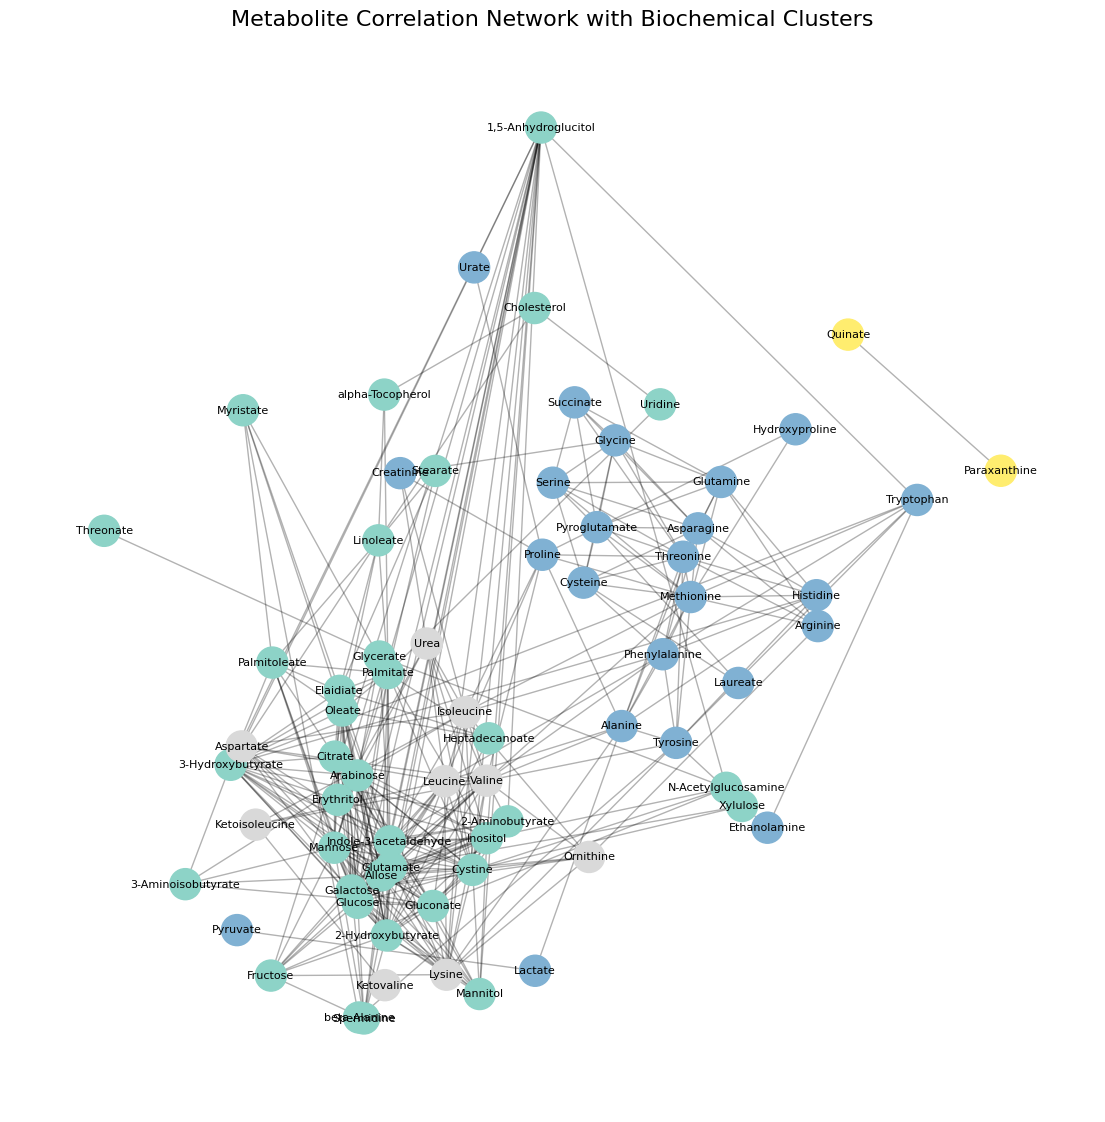

In [19]:
# Create Network Graph
corr_pairs = corr.stack().reset_index()
corr_pairs.columns = ["Feature A", "Feature B", "Correlation"]

# Filter: exclude self-correlations and weak ones
filtered = corr_pairs[
    (corr_pairs["Feature A"] != corr_pairs["Feature B"]) &
    (corr_pairs["Correlation"].abs() >= 0.4)
]

# Remove duplicate edges (A–B and B–A)
filtered["sorted_pair"] = filtered.apply(lambda row: tuple(sorted([row["Feature A"], row["Feature B"]])), axis=1)
filtered = filtered.drop_duplicates(subset="sorted_pair").drop(columns="sorted_pair")

G = nx.Graph()
# Add edges with correlation as weight
for _, row in filtered.iterrows():
    G.add_edge(row["Feature A"], row["Feature B"], weight=row["Correlation"])

communities = list(greedy_modularity_communities(G))

# Map nodes to community index
community_map = {}
for i, cluster in enumerate(communities):
    for node in cluster:
        community_map[node] = i

# Assign community ID to node attributes
nx.set_node_attributes(G, community_map, 'module')

plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, seed=42, k=0.4)

# Node color by community
node_colors = [community_map[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Set3, node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Metabolite Correlation Network with Biochemical Clusters", fontsize=16)
plt.axis('off')
plt.show()

## 3. Basic Statistics

In [20]:
# test for normal distribution 
results = []

for col in feature_cols:
    for cls in df["Class"].unique():
        data = df[df["Class"] == cls][col]
        stat, p = shapiro(data)
        results.append({
            "feature": col,
            "class": cls,
            "W-statistics": stat,
            "p-value": p,
            "Normal?": "Yes" if p > 0.05 else "No"
        })

normality_df = pd.DataFrame(results)
normality_df    


,feature,class,W-statistics,p-value,Normal?
0,"1,5-Anhydroglucitol",0,0.98,0.93,Yes
1,"1,5-Anhydroglucitol",1,0.80,0.00,No
2,2-Aminobutyrate,0,0.98,0.84,Yes
3,2-Aminobutyrate,1,0.96,0.39,Yes
4,2-Hydroxybutyrate,0,0.97,0.45,Yes
...,...,...,...,...,...
151,Uridine,1,0.94,0.07,Yes
152,Valine,0,0.95,0.15,Yes
153,Valine,1,0.96,0.32,Yes
154,Xylulose,0,0.84,0.00,No


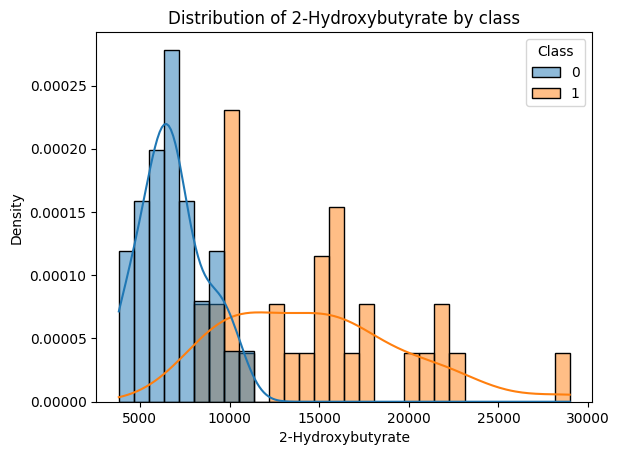

In [21]:
sns.histplot(data=df, x='2-Hydroxybutyrate', hue="Class", bins=30, kde=True, stat='density', common_norm=False)
plt.title("Distribution of 2-Hydroxybutyrate by class")
plt.show()

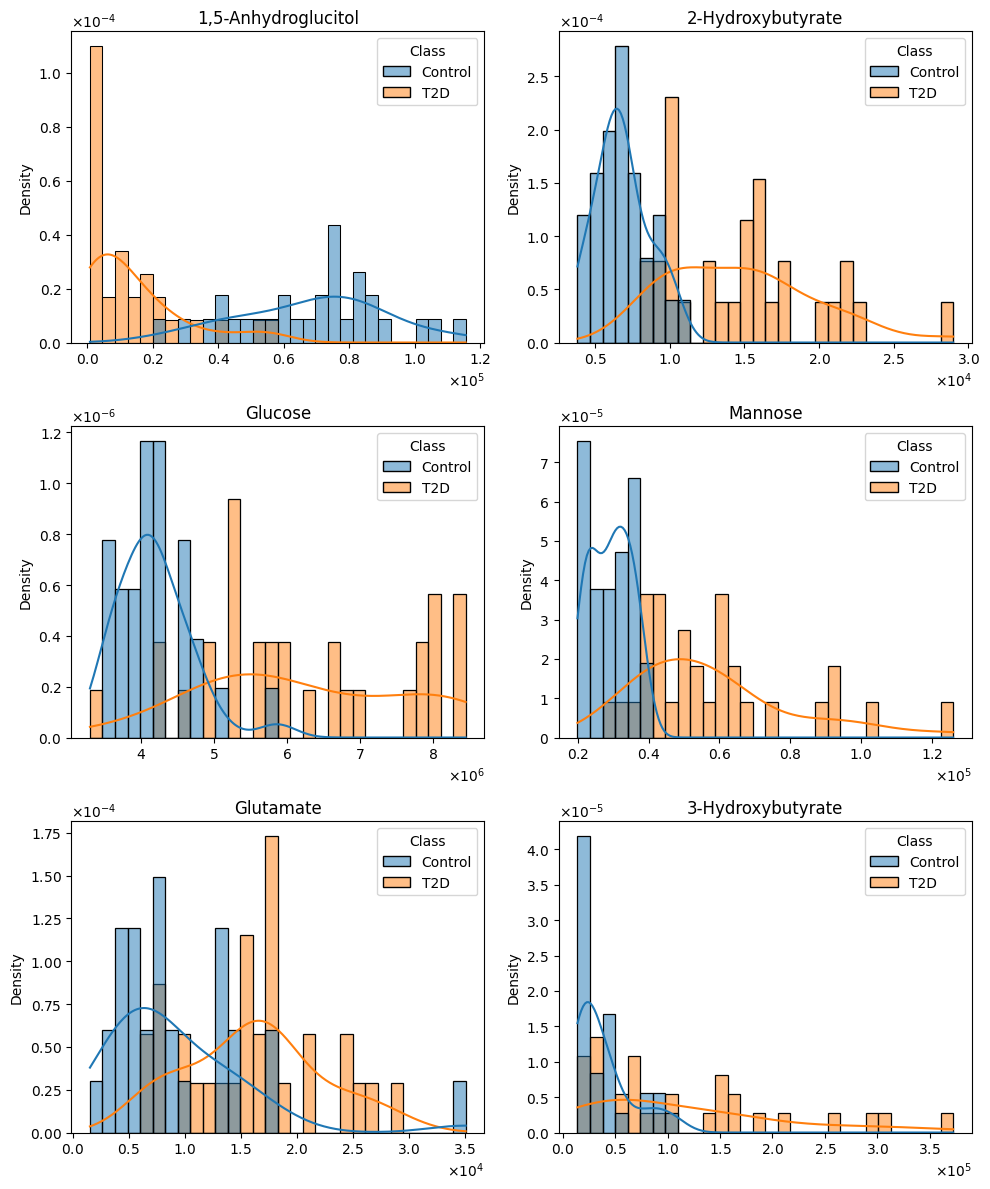

In [22]:
features_dist = ["1,5-Anhydroglucitol", "2-Hydroxybutyrate", "Glucose", "Mannose", "Glutamate", "3-Hydroxybutyrate"]

cols_per_row = 2
total_plots = len(features_dist)
rows = math.ceil(total_plots / cols_per_row)

plt.figure(figsize=(cols_per_row * 5, rows * 4))

df_plot = df.copy()
df_plot["Class"] = df_plot["Class"].map({0: "Control", 1: "T2D"})

for i, col in enumerate(features_dist):
    plt.subplot(rows, cols_per_row, i + 1)  # plt.subplots is 1-based not 0-based
    sns.histplot(data=df_plot, x=col, hue="Class", bins=30, kde=True, stat='density', common_norm=False)
    plt.title(col)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))  # Triggers sci notation only when needed
    formatter.set_scientific(True)
    formatter.set_useOffset(False)
    formatter_x = ScalarFormatter(useMathText=True)
    formatter_x.set_powerlimits((-2, 2))  # Triggers sci notation only when needed
    formatter_x.set_scientific(True)
    formatter_x.set_useOffset(False)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_formatter(formatter_x)
    plt.xlabel("")
    plt.tight_layout()

plt.show()


C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3539357636.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_numeric = heatmap_data.replace({"Yes": 1, "No": 0, "Too few samples": None})


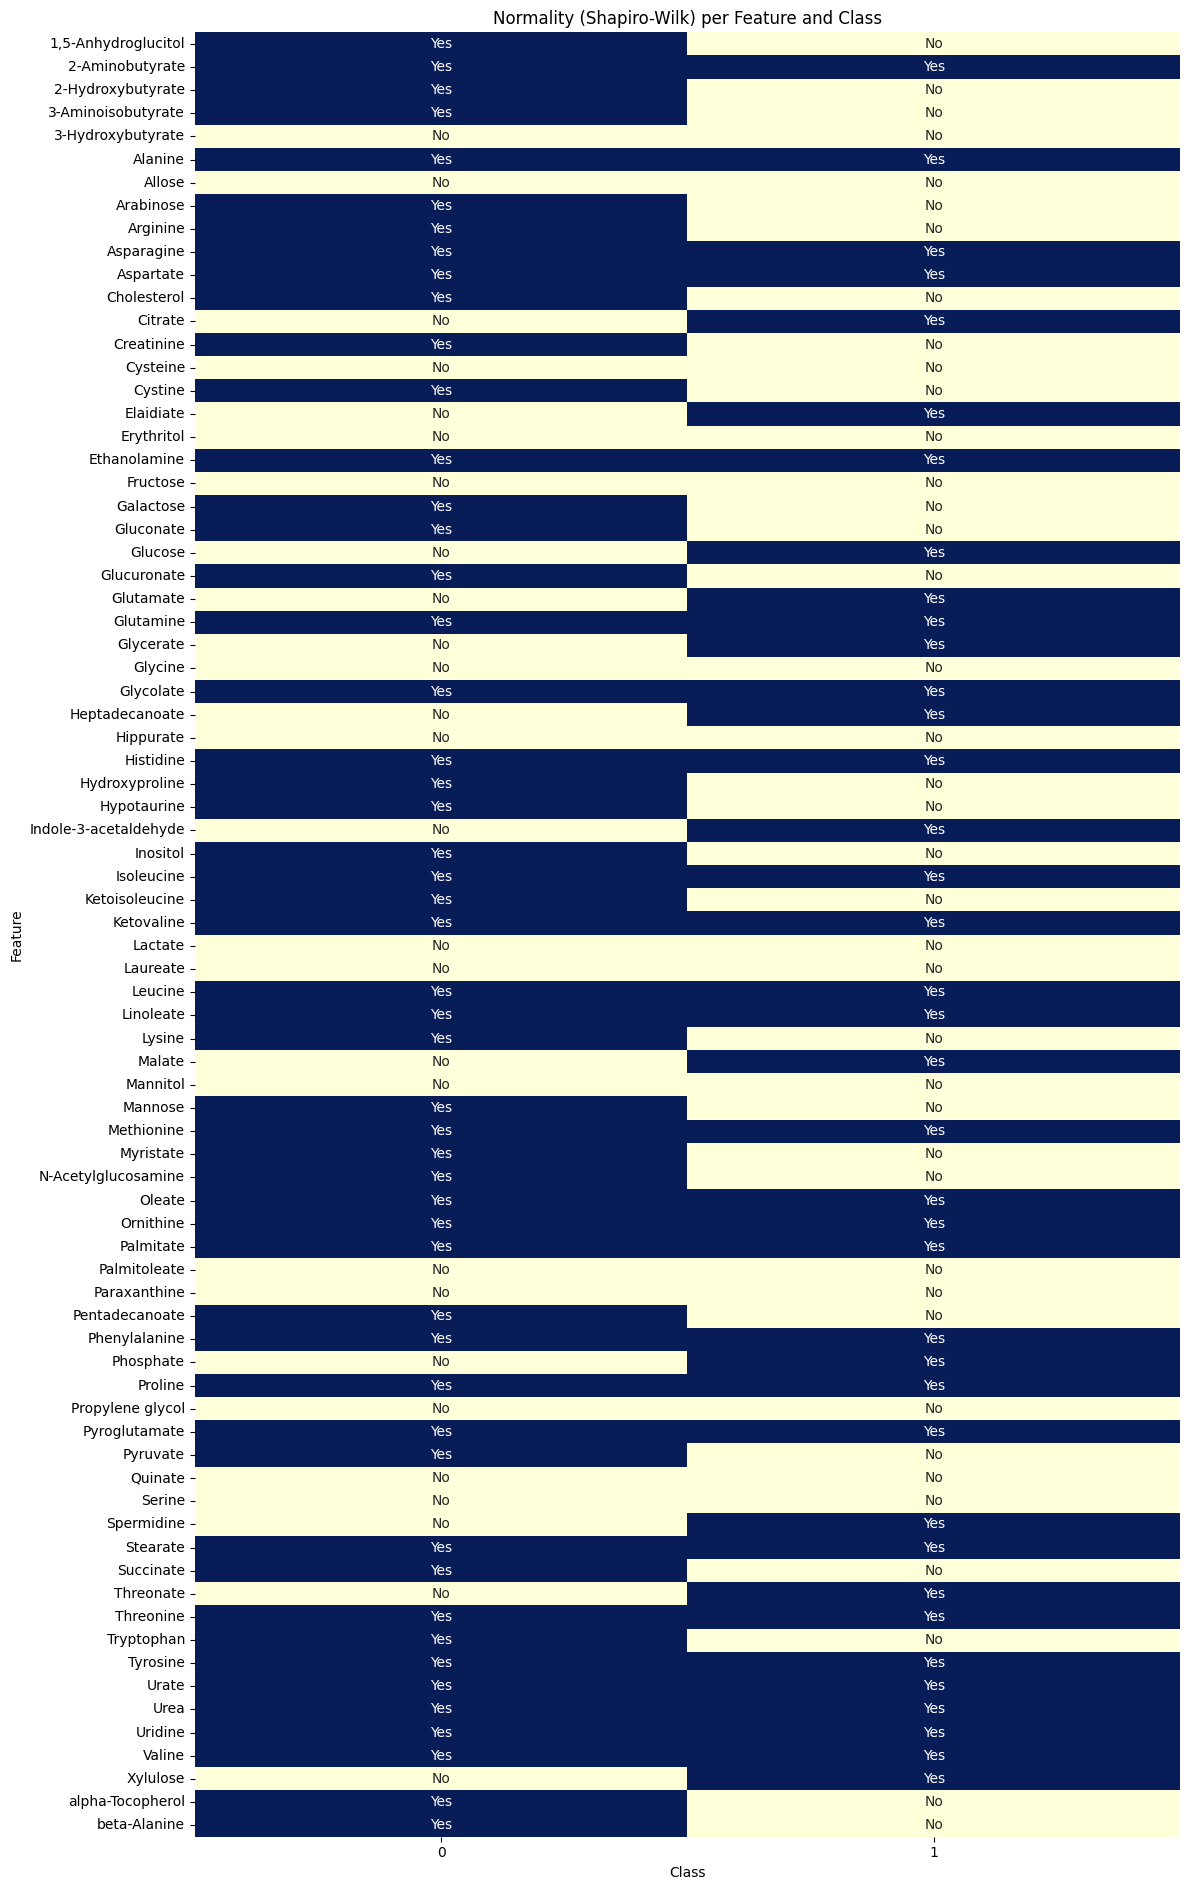

In [23]:
# Vizualise the results as heatmap for all features
heatmap_data = normality_df.pivot(index="feature", columns="class", values="Normal?")
heatmap_numeric = heatmap_data.replace({"Yes": 1, "No": 0, "Too few samples": None})
plt.figure(figsize=(12, len(feature_cols) // 4))
sns.heatmap(heatmap_numeric, annot=heatmap_data, fmt='', cmap="YlGnBu", cbar=False)
plt.title("Normality (Shapiro-Wilk) per Feature and Class")
plt.xlabel("Class")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 4. Univariate analysis

Since the data is not normally distributed, we will use the Mann–Whitney U test to compare the means between the two classes for each feature. This will become a starting point for future feature selection

In [24]:
### 1. Mann–Whitney U test

results = []

# Run Mann–Whitney U test for each feature
for feature in feature_cols:
    group_0 = df[df["Class"] == 0][feature]
    group_1 = df[df["Class"] == 1][feature]

    # impute missing values using median to prevent NaN p-values
    group_0 = SimpleImputer(strategy="median").fit_transform(group_0.values.reshape(-1, 1)).flatten()
    group_1 = SimpleImputer(strategy="median").fit_transform(group_1.values.reshape(-1, 1)).flatten()

    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')

    results.append({
        'Feature': feature,
        'U-statistic': stat,
        'p-value': p,
        "Significant?": "Yes" if p < 0.05 else "No"
    })

# Convert to DataFrame
mw_df = pd.DataFrame(results)

# Apply Benjamini–Hochberg correction (FDR-False Discovery Rate) (to reduce Type I error (false positive))
_, pvals_corrected, _, _ = multipletests(mw_df['p-value'], method='fdr_bh')
mw_df['Corrected p-value'] = pvals_corrected
mw_df['Significant (FDR < 0.05)'] = pvals_corrected < 0.05

# Sort by p-value
mw_df = mw_df.sort_values(by='Corrected p-value')

# Show or export results
mw_df.tail()

,Feature,U-statistic,p-value,Significant?,Corrected p-value,Significant (FDR < 0.05)
10,Asparagine,473.00,0.91,No,0.95,False
40,Ketovaline,456.00,0.90,No,0.95,False
25,Glucuronate,464.00,0.99,No,1.00,False
12,beta-Alanine,465.00,1.00,No,1.00,False
72,Tyrosine,467.00,0.98,No,1.00,False


In [25]:
# Check for NaN p-values
mw_df.info()

nan_pvals = mw_df[mw_df['p-value'].isna()]
nan_pvals

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 0 to 72
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Feature                   78 non-null     object 
 1   U-statistic               78 non-null     float64
 2   p-value                   78 non-null     float64
 3   Significant?              78 non-null     object 
 4   Corrected p-value         78 non-null     float64
 5   Significant (FDR < 0.05)  78 non-null     bool   
dtypes: bool(1), float64(3), object(2)
memory usage: 3.7+ KB


,Feature,U-statistic,p-value,Significant?,Corrected p-value,Significant (FDR < 0.05)


In [26]:
# Show features with significant p-values between classes
signinificant_features = mw_df[mw_df["Significant (FDR < 0.05)"] == True]

print(f"There are {len(signinificant_features)} significant features.")
signinificant_features

There are 34 significant features.


,Feature,U-statistic,p-value,Significant?,Corrected p-value,Significant (FDR < 0.05)
0,"1,5-Anhydroglucitol",904.00,0.00,Yes,0.00,True
2,2-Hydroxybutyrate,24.00,0.00,Yes,0.00,True
6,Allose,28.00,0.00,Yes,0.00,True
23,Gluconate,27.00,0.00,Yes,0.00,True
48,Mannose,32.00,0.00,Yes,0.00,True
22,Galactose,62.00,0.00,Yes,0.00,True
24,Glucose,67.00,0.00,Yes,0.00,True
36,Indole-3-acetaldehyde,77.00,0.00,Yes,0.00,True
17,Cystine,124.00,0.00,Yes,0.00,True
1,2-Aminobutyrate,141.00,0.00,Yes,0.00,True


In [27]:
def cliffs_delta(x, y):
    """
    Computes Cliff's delta effect size between two samples.
    Returns the delta value and its qualitative interpretation.
    """
    n_x = len(x)
    n_y = len(y)
    total_pairs = n_x * n_y

    greater = sum(1 for xi, yi in product(x, y) if xi > yi)
    less = sum(1 for xi, yi in product(x, y) if xi < yi)

    delta = (greater - less) / total_pairs

    abs_delta = abs(delta)
    if abs_delta < 0.147:
        magnitude = "negligible"
    elif abs_delta < 0.33:
        magnitude = "small"
    elif abs_delta < 0.474:
        magnitude = "medium"
    else:
        magnitude = "large"

    return delta, magnitude

In [28]:
### 2. Biological inference

significant_metabolites = signinificant_features["Feature"].values
control = df[df["Class"] == 0].drop(columns=["ID"])
cases = df[df["Class"] == 1].drop(columns=["ID"])

group_control = SimpleImputer(strategy="median").fit_transform(control.values.reshape(-1, 1)).flatten()
group_cases = SimpleImputer(strategy="median").fit_transform(cases.values.reshape(-1, 1)).flatten()

results = []

for metabolite in significant_metabolites:
    control_median = control[metabolite].median()
    control_values = control[metabolite]
    cases_values = cases[metabolite]

    n_higher = (cases_values > control_median).sum()
    n_lower = (cases_values < control_median).sum()
    total = len(cases_values)

    delta, magnitude = cliffs_delta(cases_values, control_values)

    results.append({
        'Metabolite': metabolite,
        'Control Median': control_median,
        'N T2D Higher': n_higher,
        'N T2D Lower': n_lower,
        'Total T2D': total,
        'Proportion Higher': n_higher / total,
        'Proportion Lower': n_lower / total,
        'Cliffs Delta': delta,
        'Effect Size': magnitude
    })

biological_df = pd.DataFrame(results)
biological_df

,Metabolite,Control Median,N T2D Higher,N T2D Lower,Total T2D,Proportion Higher,Proportion Lower,Cliffs Delta,Effect Size
0,"1,5-Anhydroglucitol",72441.11,0,31,31,0.00,1.00,-0.94,large
1,2-Hydroxybutyrate,6667.66,31,0,31,1.00,0.00,0.95,large
2,Allose,10301.21,31,0,31,1.00,0.00,0.91,large
3,Gluconate,828.79,30,1,31,0.97,0.03,0.94,large
4,Mannose,29906.15,30,1,31,0.97,0.03,0.93,large
5,Galactose,672210.16,30,1,31,0.97,0.03,0.87,large
6,Glucose,4143208.24,30,1,31,0.97,0.03,0.86,large
7,Indole-3-acetaldehyde,27286.89,29,2,31,0.94,0.06,0.83,large
8,Cystine,1751.66,29,2,31,0.94,0.06,0.73,large
9,2-Aminobutyrate,1608.16,28,3,31,0.90,0.10,0.70,large


In [29]:
#df.to_csv("ST001906_1.csv", index=False)